<a href="https://colab.research.google.com/github/BaranovMykola/ABTO-CV-Coins/blob/master/ml_landscape_cv2_xphoto_inpaint_mobilenet_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Landscape classification

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle'

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
  Using cached kaggle-1.5.12-py3-none-any.whl


In [4]:
!mkdir -p /kaggle/input
!kaggle datasets download -d meowmeowmeowmeowmeow/ml-olympiad-landscape-opencv-xpoto-inpain-fast -p /kaggle/input

 96% 329M/342M [00:10<00:00, 37.2MB/s]
100% 342M/342M [00:10<00:00, 35.6MB/s]


In [8]:
!kaggle competitions download -c ml-olympiad-landscape-image-classification -p /kaggle/input

 83% 113M/135M [00:04<00:00, 30.7MB/s] 
100% 135M/135M [00:04<00:00, 33.8MB/s]


In [9]:
!unzip /kaggle/input/ml-olympiad-landscape-image-classification.zip -d /kaggle/input > /dev/null
!unzip /kaggle/input/ml-olympiad-landscape-opencv-xpoto-inpain-fast.zip -d /kaggle/input > /dev/null

In [10]:
!ls /kaggle/input

ml-olympiad-landscape-image-classification.zip	    test	  train
ml-olympiad-landscape-opencv-xpoto-inpain-fast.zip  test.csv	  train.csv
sample.csv					    test_inpaint  train_inpaint


Import necessary packages.

In [11]:

# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

   
import os
import random
import tensorflow as tf
import tensorflow_hub as hub
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from pathlib import Path

# You can write up to 20GB to the current directory (/kaggle/wo`rking/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
RANDOM_STATE = 0
def seed_everything(seed=RANDOM_STATE):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
seed_everything()

## Setting parameters & constants

In [13]:
PATH_INITIAL_FILES = Path('/kaggle/input/')
PATH_INPAINT_IMAGES_OPENCV = Path('/kaggle/input')

IMAGES_SOURCE = PATH_INPAINT_IMAGES_OPENCV
FOLDER_TRAIN_IMAGES = IMAGES_SOURCE / 'train_inpaint'
FOLDER_TEST_IMAGES = IMAGES_SOURCE / 'test_inpaint'


## Data preparation

In [14]:
all_data = pd.read_csv(PATH_INITIAL_FILES / 'train.csv')
# all_data = pd.read_csv(path+'train.csv')
all_data = all_data.sample(frac=1)
all_data.head(4)

,image,label
6390,buildings/98055737.jpg,buildings
1667,sea/13636620.jpg,sea
13737,glacier/16633141.jpg,glacier
11855,sea/14549171.jpg,sea


In [15]:
pd.options.display.max_colwidth = 300
train_data = all_data.copy()
train_data.image = train_data.image.apply(lambda x: str(FOLDER_TRAIN_IMAGES / x))

lbl_coder = LabelEncoder()
lbl_coder.fit(train_data.label)


train_data['lbl_id'] = lbl_coder.transform(train_data.label)
train_data.sample(5)

,image,label,lbl_id
6261,/kaggle/input/train_inpaint/street/56912216.jpg,street,5
9202,/kaggle/input/train_inpaint/buildings/17764503.jpg,buildings,0
12526,/kaggle/input/train_inpaint/glacier/77974047.jpg,glacier,2
3496,/kaggle/input/train_inpaint/mountain/97245467.jpg,mountain,3
12109,/kaggle/input/train_inpaint/mountain/13573478.jpg,mountain,3


In [16]:
train_data['exist'] = train_data.image.apply(lambda x: os.path.exists(x))
train_data_filtered = train_data[train_data.exist]

assert len(train_data_filtered) == len(train_data), 'Some of image files does not exist'
train_data = train_data_filtered
train_data.shape

(14034, 4)

In [17]:
def k_fold_split_data(fold_id):
    csv_train = train_data.iloc[folds[fold_id][0]].sample(frac=1)
    csv_val = train_data.iloc[folds[fold_id][1]]
    
    return csv_train, csv_val

def plot_data(csv_train, csv_val):
    fig, ax = plt.subplots(figsize=(24, 6), ncols=2)

    train_species_dist = csv_train.label.value_counts().reset_index()
    val_species_dist = csv_val.label.value_counts().reset_index()

    ax[0].bar(train_species_dist['index'], train_species_dist.label)
    ax[1].bar(val_species_dist['index'], val_species_dist.label)

    for tick in ax[0].get_xticklabels():
        tick.set_rotation(80)

    for tick in ax[1].get_xticklabels():
        tick.set_rotation(80)

In [58]:
def load_img(x):
    img_data = tf.io.read_file(x)
    img = tf.image.decode_jpeg(img_data, channels=3)
#     img = tf.random.uniform(shape=[128, 128, 3])
    return img

def normalize(img):
    img = tf.cast(img, tf.float32)
    img /= 255
    return img

def encode_l(x):
    return tf.one_hot(x, 6)

def load_base_ds(paths, labels, aug=False):
    ds_i = tf.data.Dataset.from_tensor_slices(paths)
    
    ds_i = ds_i.map(load_img).map(normalize)
    
    if aug:
        ds_i = ds_i.map(augment)
        
    if labels is not None:
        ds_l = tf.data.Dataset.from_tensor_slices(labels).map(encode_l)
        ds = tf.data.Dataset.zip((ds_i, ds_l))
    else:
        ds = ds_i
        
    return ds

def augment(img):
    img = tf.image.random_contrast(img, 0.3, 1.3)
    img = tf.image.random_brightness(img, 0.1)
    #img = tf.image.random_hue(img, 0.1)
    img = tf.image.random_saturation(img, 0.7, 1.3)
    
#     img = tf.image.random_crop(img, size=[224, 224, 3])
    img = tf.image.random_flip_left_right(img)
    
    img = tf.clip_by_value(img, 0, 1)
    return img

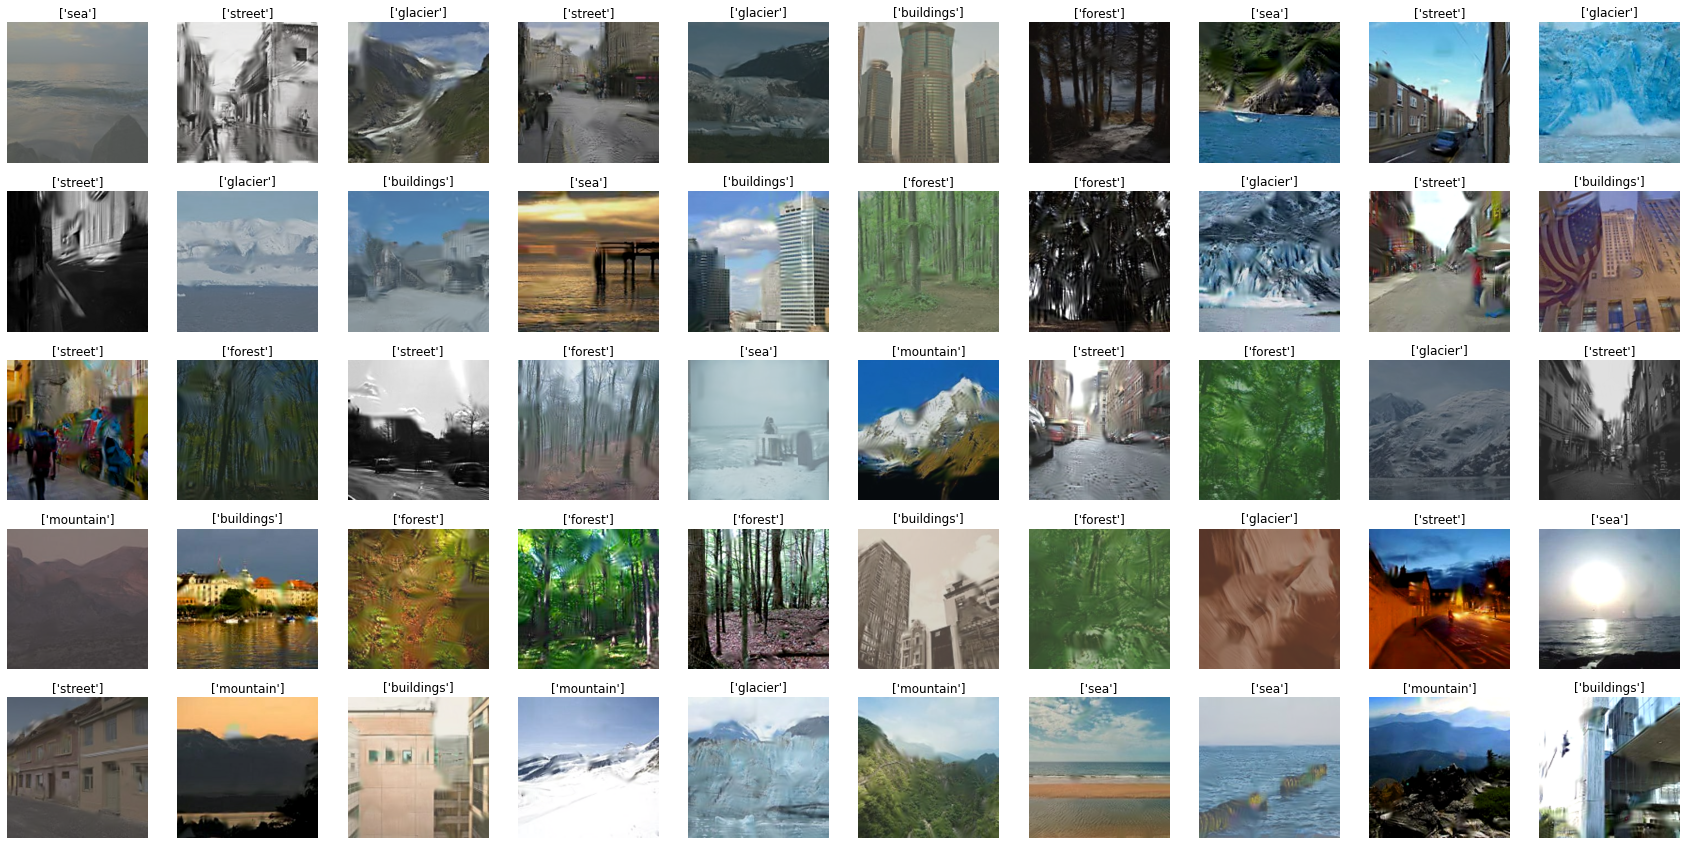

In [59]:
fig, ax = plt.subplots(ncols=10, nrows=5, figsize=(30, 15))
ax = ax.ravel()

csv_slice = train_data.sample(50)
_ds = load_base_ds(csv_slice.image, csv_slice.lbl_id, aug=True)

for i, (sample, lbl) in enumerate(_ds):
  ax[i].imshow(sample)
  ax[i].set_title(lbl_coder.inverse_transform([np.argmax(lbl)]))
  ax[i].axis('off')

In [20]:
def visualise_images_samples(ds_train):
    fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(24, 8))
    ax = ax.ravel()

    for i, (img, lbl) in enumerate(ds_train.take(8)):
        ax[i].imshow(img)
        ax[i].set_title(lbl_coder.inverse_transform([np.argmax(lbl)])[0])
        ax[i].set_xticks([])
        ax[i].set_yticks([])

In [40]:
def visualize_results(h1, h2):
    loss = h1.history['loss']
    val_loss = h1.history['val_loss']
    acc = h1.history['categorical_accuracy']
    val_acc = h1.history['val_categorical_accuracy']

    #loss2 = h2.history['loss']
    #val_loss2 = h2.history['val_loss']
    #acc2 = h2.history['categorical_accuracy']
    #val_acc2 = h2.history['val_categorical_accuracy']

    fig, ax = plt.subplots(figsize=(24, 4), ncols=2)

    ax[0].plot(loss, label='Train loss', c='tab:blue')
    #ax[0].plot(range(len(loss), len(loss2)), loss2, c='tab:blue')

    ax[0].plot(val_loss, label='Validation loss', c='tab:green')
    #ax[0].plot(range(len(loss)), val_loss2, c='tab:green')


    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss value');

    ax[1].plot(acc, label='Train accruacy', c='tab:blue')
    #ax[1].plot(range(len(loss)), acc2, c='tab:blue')

    ax[1].plot(val_acc, label='Validation accuracy', c='tab:green')
    #ax[1].plot(range(len(loss)), val_acc2, c='tab:green')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy');

    for _ax in ax:
        _ax.grid()
        _ax.legend()

    fig.suptitle('Loss & Accuracy visualization', fontsize=16);

In [23]:
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.matshow(cm)
    ax.set_xticks(range(6));
    ax.set_xticklabels(lbl_coder.inverse_transform(range(6)));

    for tick in ax.get_xticklabels():
        tick.set_rotation(80)

    ax.set_yticks(range(6));
    ax.set_yticklabels(lbl_coder.inverse_transform(range(6)));

    for tick in ax.get_yticklabels():
        tick.set_rotation(20)

    ax.grid(color='w', linestyle='-', linewidth=1, alpha=0.3)

In [24]:
def save_predictions(model, path_input_csv: Path, path_images_folder: Path, is_test_data: bool=True, fold_id=None):
    # Read sample output
    csv_test = pd.read_csv(path_input_csv)
    #Extract filenames
    files = [str(path_images_folder / x) for x in csv_test.image]
    #Read test images
    ds_test = load_base_ds(files, None)
    # Predict test images
    predictions = m.predict(ds_test.batch(32))
    # Save predictions to dataframe with classes
    predictions_df = pd.DataFrame(predictions, columns=lbl_coder.classes_)
    
    names_df = csv_test
    # Delete fake labels in case this is test data
    if is_test_data:
        names_df = csv_test.drop('label', axis=1)
    # Merge predictions and filenames dataframes into one 
    total_df = pd.merge(names_df, predictions_df, left_index=True, right_index=True)
    # Dump dataframe to the disk
    total_df.to_csv(f"predictions_fold_{fold_id}.csv")
    
    return total_df

## Model architecture

In [31]:
def get_model():
    m = tf.keras.Sequential([
        hub.KerasLayer("https://tfhub.dev/google/bit/s-r50x1/1",
                       trainable=False),  # Can be True, see below.
        tf.keras.layers.Dense(256, activation=tf.keras.activations.elu),
    #     tf.keras.layers.Dropout(0.3),
    #     tf.keras.layers.Dense(256, activation=tf.keras.activations.selu),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

    m.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return m


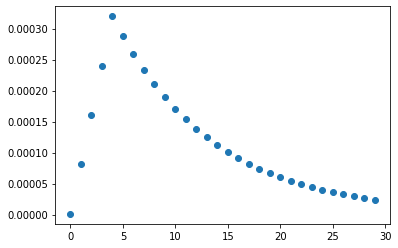

In [61]:
def get_lr_callback(e, plot=False):
    lr_start   = 0.000001
    lr_max     = 0.000005 * 64
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(e))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(30, plot=True)

In [64]:
def fit(m, train_data, validation_data, epochs=5, ckpt_path = './best_compet'):
    lr = get_lr_callback(epochs)
    sv = tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_categorical_accuracy', save_best_only=True, save_weights_only=True)
    #history1 = m.fit(_ds_train, validation_data=_ds_val, epochs=epochs, callbacks=[lr, sv])
    #m.layers[0].trainable = True
    history2 = m.fit(_ds_train, validation_data=_ds_val, epochs=epochs, callbacks=[lr, sv], steps_per_epoch=14000//64//5)
    
    return history2, None

In [ ]:
def prepare_to_train(dataset):
    return dataset.batch(64).prefetch(128)

K_FOLD_N_SPLITS = 5
list_ith_fold = []

fold_val_scores = []
test_predictions = []

folds = list(StratifiedKFold(K_FOLD_N_SPLITS, shuffle=True, random_state=RANDOM_STATE).split(train_data, train_data.label))
for fold_id in range(K_FOLD_N_SPLITS):
    
    print(f"Fold # {fold_id}")
    csv_train, csv_val = k_fold_split_data(fold_id)
    ds_train = load_base_ds(csv_train.image, csv_train.lbl_id, True)
    ds_val = load_base_ds(csv_val.image, csv_val.lbl_id)

    _ds_train = prepare_to_train(ds_train)
    _ds_val = prepare_to_train(ds_val)
    
    m = get_model()
    path_checkpoint = f'./best_checkpoint_fold_{fold_id}'
    history1, history2 = fit(m, _ds_train, _ds_val, epochs=3, ckpt_path=path_checkpoint)

    visualize_results(history1, None)

    m.load_weights(path_checkpoint)

    val_pred = m.predict(_ds_val)
    val_pred = np.argmax(val_pred, axis=-1)

    val_gt = [y for x, y in _ds_val]
    val_gt = np.argmax(np.concatenate(val_gt), axis=-1)
    cm = confusion_matrix(val_gt, val_pred)
    cm_row_sum = np.sum(cm, axis=0)
    cm = cm / cm_row_sum

    plot_confusion_matrix(cm)
    
    save_predictions(m, PATH_INITIAL_FILES / 'train.csv', FOLDER_TRAIN_IMAGES, is_test_data=False, fold_id = fold_id)
    current_m_test_predictions = save_predictions(m, PATH_INITIAL_FILES / 'sample.csv', FOLDER_TEST_IMAGES, is_test_data=True)
    test_predictions.append(current_m_test_predictions)
    
    current_fold_val_score = m.evaluate(_ds_val)[1]
    fold_val_scores.append(current_fold_val_score)
    del m
    
    print('\n======================================================')
    print(f'Fold #{fold_id} | Val: {current_fold_val_score:0.5f} |')
    print('======================================================', end='\n\n')
    break

Fold # 0
Epoch 1/3
43/43 [==============================] - 66s 1s/step - loss: 2.3365 - categorical_accuracy: 0.1384 - val_loss: 2.2546 - val_categorical_accuracy: 0.1578 - lr: 1.0000e-06
Epoch 2/3
43/43 [==============================] - 47s 1s/step - loss: 0.9422 - categorical_accuracy: 0.6508 - val_loss: 0.4910 - val_categorical_accuracy: 0.8279 - lr: 8.0750e-05
Epoch 3/3
43/43 [==============================] - ETA: 0s - loss: 0.4171 - categorical_accuracy: 0.8539

In [ ]:
plt.figure(figsize=(18, 3))
plt.bar(range(K_FOLD_N_SPLITS), fold_val_scores)
plt.xlabel('#Fold', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.title(f'Mean score: {np.mean(fold_val_scores):0.5f} | Std: {np.std(fold_val_scores):0.5f}', fontsize=16)

In [ ]:
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
avg_test_score = (test_predictions[0][labels] + test_predictions[1][labels] + test_predictions[2][labels] + 
                  test_predictions[3][labels] + test_predictions[4][labels])/5

csv_test = pd.read_csv('/kaggle/input/ml-olympiad-landscape-image-classification/sample.csv')
prediction_ids = np.argmax(avg_test_score.to_numpy(), axis=-1)

In [ ]:
str_pred = lbl_coder.inverse_transform(prediction_ids)
csv_test.label = str_pred
csv_test.to_csv('./submission.csv', index=False)
